- GitHub: https://github.com/mahmood1989?tab=repositories
- Email: mahmoodr@ualberta.ca

# Breast Cancer Gene Expression Profiles
# Model 2 - General Features without Gen Expression Data
In this notebook, I just used the general data as input features of the model (Columns B to AD).

## Import Python libraries

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier


import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image as Image

import seaborn as sn

## General structure of training spreadsheet

The source of this dataset can be downloaded through Kaggle:

https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric

In [2]:
df_raw = pd.read_excel('Model_2.xlsx')
df_raw.head(10)

,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,er_status_measured_by_ihc,neoplasm_histologic_grade,her2_status,tumor_other_histologic_subtype,...,integrative_cluster,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,death_from_cancer
0,75.65,MASTECTOMY,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,Positve,3.0,Negative,Ductal/NST,...,4ER+,10,NaN,6.044,IDC,Negative,1,ER-/HER2-,22.0,Living
1,43.19,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,High,0,LumA,Positve,3.0,Negative,Ductal/NST,...,4ER+,0,2.0,4.020,IDC,Positive,1,ER+/HER2- High Prolif,10.0,Living
2,48.87,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,1,LumB,Positve,2.0,Negative,Ductal/NST,...,3,1,2.0,4.030,IDC,Positive,0,NaN,15.0,Died of Disease
3,47.68,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,Positve,2.0,Negative,Mixed,...,9,3,1.0,4.050,MDLC,Positive,1,NaN,25.0,Living
4,76.97,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,Positve,3.0,Negative,Mixed,...,9,8,2.0,6.080,MDLC,Positive,1,ER+/HER2- High Prolif,40.0,Died of Disease
5,78.77,MASTECTOMY,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,Positve,3.0,Negative,Ductal/NST,...,7,0,4.0,4.062,IDC,Positive,1,ER+/HER2- High Prolif,31.0,Died of Disease
6,56.45,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,Moderate,1,LumB,Positve,2.0,Negative,Ductal/NST,...,3,1,4.0,4.020,IDC,Positive,1,NaN,10.0,Living
7,89.08,BREAST CONSERVING,Breast Mixed Ductal and Lobular Carcinoma,Moderate,0,claudin-low,Positve,2.0,Negative,Mixed,...,3,1,1.0,4.058,MDLC,Negative,1,NaN,29.0,Died of Other Causes
8,86.41,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,Positve,3.0,Negative,Ductal/NST,...,9,1,4.0,5.032,IDC,Negative,1,ER+/HER2- High Prolif,16.0,Died of Other Causes
9,84.22,MASTECTOMY,Breast Invasive Lobular Carcinoma,High,0,Her2,Negative,2.0,Negative,Lobular,...,3,0,5.0,3.056,ILC,Negative,0,ER+/HER2- High Prolif,28.0,Died of Disease


There are 1904 attributes from 21 different fearures. 1 feature (death_from_cancer) is the output feature.

In [3]:
df_raw.shape

(1904, 22)

There are many null cells and we need to delete them.

In [4]:
df_raw.isna().sum()

age_at_diagnosis                    0
type_of_breast_surgery             22
cancer_type_detailed               15
cellularity                        54
chemotherapy                        0
pam50_+_claudin-low_subtype         0
er_status_measured_by_ihc          30
neoplasm_histologic_grade          72
her2_status                         0
tumor_other_histologic_subtype     15
hormone_therapy                     0
inferred_menopausal_state           0
integrative_cluster                 0
lymph_nodes_examined_positive       0
mutation_count                     45
nottingham_prognostic_index         0
oncotree_code                      15
pr_status                           0
radio_therapy                       0
3-gene_classifier_subtype         204
tumor_size                         20
death_from_cancer                   1
dtype: int64

After deleting the null row, we will have 1498 attributes. 

In [5]:
df_raw.dropna(inplace = True)

In [6]:
df_raw.shape

(1498, 22)

## Convert string variables to categorical classes

In [7]:
df_raw.dtypes

age_at_diagnosis                  float64
type_of_breast_surgery             object
cancer_type_detailed               object
cellularity                        object
chemotherapy                        int64
pam50_+_claudin-low_subtype        object
er_status_measured_by_ihc          object
neoplasm_histologic_grade         float64
her2_status                        object
tumor_other_histologic_subtype     object
hormone_therapy                     int64
inferred_menopausal_state          object
integrative_cluster                object
lymph_nodes_examined_positive       int64
mutation_count                    float64
nottingham_prognostic_index       float64
oncotree_code                      object
pr_status                          object
radio_therapy                       int64
3-gene_classifier_subtype          object
tumor_size                        float64
death_from_cancer                  object
dtype: object

In [8]:
df = df_raw.copy(deep = True)

### 1. Binary (tertiary) variables

In [9]:
df['type_of_breast_surgery'].replace('BREAST CONSERVING', 1, inplace = True)
df['type_of_breast_surgery'].replace('MASTECTOMY', 0, inplace = True)

In [10]:
df['cellularity'].replace('High', 2, inplace = True)
df['cellularity'].replace('Moderate', 1, inplace = True)
df['cellularity'].replace('Low', 0, inplace = True)

In [11]:
df['er_status_measured_by_ihc'].replace('Positve', 1, inplace = True)
df['er_status_measured_by_ihc'].replace('Negative', 0, inplace = True)

In [12]:
df['her2_status'].replace('Positive', 1, inplace = True)
df['her2_status'].replace('Negative', 0, inplace = True)

In [13]:
df['inferred_menopausal_state'].replace('Post', 1, inplace = True)
df['inferred_menopausal_state'].replace('Pre', 0, inplace = True)

In [14]:
df['pr_status'].replace('Positive', 1, inplace = True)
df['pr_status'].replace('Negative', 0, inplace = True)

The output ('death_from_cancer') is the string type with three categories as:
- Living (Class 0)
- Died of Other Causes (Class 0)
- Died of Disease (Class 1)
If a patient dies because of cancer, we categorize it as Class 1, otherwise Class 0 is assigned.

In [15]:
df['death_from_cancer'].replace('Living', 0, inplace = True)
df['death_from_cancer'].replace('Died of Other Causes', 0, inplace = True)
df['death_from_cancer'].replace('Died of Disease', 1, inplace = True)

Among 1498 cases in this dataset, 495 patients died from cancer (33% of total).

In [16]:
(df.death_from_cancer == 1).sum()

495

In [17]:
df.shape

(1498, 22)

### 2. One Hot Encodding 

The following features are converted to dummy input variables.

In [18]:
df = pd.get_dummies(data = df, columns = ['cancer_type_detailed', 'pam50_+_claudin-low_subtype',\
'tumor_other_histologic_subtype', 'integrative_cluster', 'oncotree_code', '3-gene_classifier_subtype'])

Now we have 54 input features from 1498 attributes. 1 feature in the output data.

In [19]:
df.shape

(1498, 55)

## Normalization of input parameters

The following float features are normalzied to have a range from 0 to 1. 

In [20]:
df_norm = pd.DataFrame()
df_norm = df[['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', \
              'tumor_size']].copy()

In [21]:
df_norm = df_norm.apply(lambda x: (x - x.min(axis = 0)) / ((x.max(axis = 0)) - (x.min(axis = 0))))

In [22]:
df[['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', \
              'tumor_size']] = df_norm[['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', \
                                   'nottingham_prognostic_index', \
              'tumor_size']]

As listed below, all features are converted to numbers and normalized if needed.

In [23]:
df.head(10)

,age_at_diagnosis,type_of_breast_surgery,cellularity,chemotherapy,er_status_measured_by_ihc,neoplasm_histologic_grade,her2_status,hormone_therapy,inferred_menopausal_state,lymph_nodes_examined_positive,...,integrative_cluster_4ER-,oncotree_code_BREAST,oncotree_code_IDC,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MDLC,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+
1,0.285906,1,2,0,1,3.0,0,1,0,0.000000,...,0,0,1,0,0,0,1,0,0,0
4,0.740183,0,2,1,1,3.0,0,1,1,0.195122,...,0,0,0,0,0,1,1,0,0,0
5,0.764389,0,1,0,1,3.0,0,1,1,0.000000,...,0,0,1,0,0,0,1,0,0,0
8,0.867133,1,1,0,1,3.0,0,1,1,0.024390,...,0,0,1,0,0,0,1,0,0,0
9,0.837682,0,2,0,0,2.0,0,0,1,0.000000,...,0,0,0,1,0,0,1,0,0,0
10,0.854761,0,1,0,1,2.0,0,1,1,0.000000,...,0,0,1,0,0,0,0,1,0,0
19,0.316030,1,2,1,1,3.0,0,1,0,0.000000,...,0,0,1,0,0,0,1,0,0,0
22,0.532006,1,2,0,1,2.0,0,1,1,0.024390,...,0,0,1,0,0,0,1,0,0,0
30,0.628698,0,0,1,0,3.0,0,0,1,0.000000,...,0,0,1,0,0,0,0,0,1,0
31,0.335664,0,1,0,1,2.0,0,1,0,0.000000,...,0,0,0,1,0,0,0,1,0,0


## Univariate Selection
We will have 54 input features that may result in overfitting of the ML model. We should filter the input variables that have stronger correlation with the output variable. One technique is "Univariate Selection".

In [24]:
# The input data of this function is df2_regression or df2_classification

def Univariate_Selection (df2, n_features):
    X = df2.drop('death_from_cancer', axis = 'columns')
    y = df2['death_from_cancer']
    
    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(X,y)
    
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    feature_Scores = pd.concat([dfcolumns,dfscores], axis=1)
    feature_Scores.columns = ['Specs','Score']
    
    Top_features = feature_Scores.nlargest(n_features,'Score')
    
    X_featured_US = pd.DataFrame()  
    for ii in Top_features['Specs']:
        X_featured_US[ii] = X[ii]

    X = X_featured_US.copy()
    X = np.array(X)    
    y = np.array(y)
             
    
    print(Top_features)
    
    return(X, y)


# Machine Learning Models
In this section, we test the performance of different classification models.

## 1. Random Forest
We use Univariate_Selection and come up with n_feature = 20 as the optimum number of features out of 54 features.

In [25]:
X, y = Univariate_Selection (df, n_features = 20)

                                                Specs      Score
37                              integrative_cluster_5  45.582306
6                                         her2_status  32.948072
3                                        chemotherapy  32.422593
51     3-gene_classifier_subtype_ER+/HER2- Low Prolif  31.215246
53                    3-gene_classifier_subtype_HER2+  29.915362
22                   pam50_+_claudin-low_subtype_LumA  27.257431
36                              integrative_cluster_3  21.067066
21                   pam50_+_claudin-low_subtype_Her2  19.203529
9                       lymph_nodes_examined_positive  17.360078
1                              type_of_breast_surgery  14.024467
11                        nottingham_prognostic_index  13.966838
35                              integrative_cluster_2  10.138265
12                                          pr_status   8.017459
5                           neoplasm_histologic_grade   6.610283
33  tumor_other_histologi

There are several important hyperprameters that should be optimized in the Random Forest model. We use GridSearchCV to find the optimum values of these hyperparameters that result in the maximum accuracy. The algorithm came up with the following values:

ccp_alpha = 0.005, max_depth = 30, max_leaf_nodes = 50, n_estimators = 75

In [26]:
param_grid = [
    {'ccp_alpha' : [0.0005, 0.001, 0.005, 0.01],
     'max_depth' : [20, 30, 40, 50],
     'max_leaf_nodes' : [30, 40, 50],
     'n_estimators' : [50, 75, 100, 125]   
    }
]

optimal_params = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, scoring = 'accuracy')

optimal_params.fit(X, y)

print(optimal_params.best_params_)

{'ccp_alpha': 0.005, 'max_depth': 30, 'max_leaf_nodes': 50, 'n_estimators': 75}


We use K-fold cross validation to get the average of accuracy over different cross validation sets.

In [27]:
Random_forest_models = cross_val_score(RandomForestClassifier(ccp_alpha = 0.005, max_depth = 30, max_leaf_nodes = 50, \
                                                              n_estimators = 75),X, y,cv = 10)
Random_forest_models

array([0.74      , 0.74      , 0.67333333, 0.71333333, 0.65333333,
       0.71333333, 0.7       , 0.68      , 0.71812081, 0.73154362])

In [28]:
np.mean(Random_forest_models)

0.7062997762863535

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [30]:
Random_forest = RandomForestClassifier(ccp_alpha = 0.005, max_depth = 30, max_leaf_nodes = 50, n_estimators = 75)

In [31]:
Random_forest.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.005, max_depth=30, max_leaf_nodes=50,
                       n_estimators=75)

Model accuracy is on test data in 0.70.

In [32]:
Random_forest.score(X_test, y_test)

0.7033333333333334

Model accuracy is on test data in around 0.29 which is higher than the accuracy of logistic regression models.

In [33]:
y_predicted = Random_forest.predict(X_test)

As shown in the confusion matrix below, the Random Forest model does not have a good accuracy for prediction of class = 1.

Text(69.0, 0.5, 'Truth')

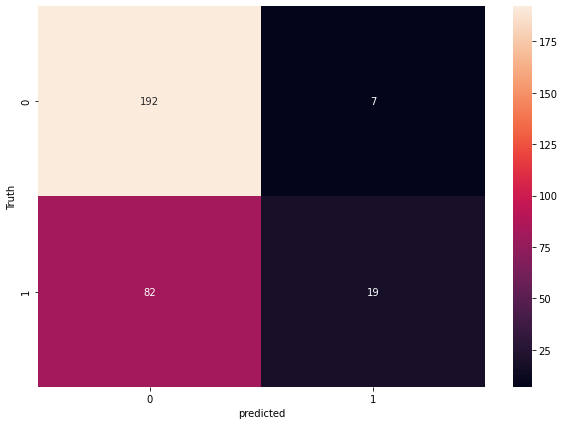

In [34]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-Score for Class = 0 is 0.81 which is relatively good. However, F-score of Class = 1 is 0.30 which is very low. The weighted average F-score is 0.64.

In [35]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81       199
           1       0.73      0.19      0.30       101

    accuracy                           0.70       300
   macro avg       0.72      0.58      0.56       300
weighted avg       0.71      0.70      0.64       300



#### Random Forest in Model 2 with 20 features has relatively higher accuracy compared to the Random Forest in Model 1 with 100 features!

## 2. Gradient Boost

Similar to the Random Forest model, we use Univariate_Selection and n_feature = 20 as the optimum number of features.

In [36]:
X, y = Univariate_Selection (df, n_features = 20)

                                                Specs      Score
37                              integrative_cluster_5  45.582306
6                                         her2_status  32.948072
3                                        chemotherapy  32.422593
51     3-gene_classifier_subtype_ER+/HER2- Low Prolif  31.215246
53                    3-gene_classifier_subtype_HER2+  29.915362
22                   pam50_+_claudin-low_subtype_LumA  27.257431
36                              integrative_cluster_3  21.067066
21                   pam50_+_claudin-low_subtype_Her2  19.203529
9                       lymph_nodes_examined_positive  17.360078
1                              type_of_breast_surgery  14.024467
11                        nottingham_prognostic_index  13.966838
35                              integrative_cluster_2  10.138265
12                                          pr_status   8.017459
5                           neoplasm_histologic_grade   6.610283
33  tumor_other_histologi

We use GridSearchCV to find the optimum values of the hyperparameters, in particular learning rate.

In [37]:
param_grid = [
    {'learning_rate' : [0.001, 0.01, 0.1, 0.15],
     'n_estimators' : [50, 80, 100, 150]
    }
]

optimal_params = GridSearchCV(GradientBoostingClassifier(), param_grid, cv = 5, scoring = 'accuracy')

optimal_params.fit(X, y)

print(optimal_params.best_params_, optimal_params.best_score_)

{'learning_rate': 0.01, 'n_estimators': 150} 0.6975875139353399


In [38]:
Boost_models = cross_val_score(GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 150),X, y,cv = 10)
Boost_models

array([0.75333333, 0.71333333, 0.68666667, 0.69333333, 0.66      ,
       0.7       , 0.68666667, 0.67333333, 0.7114094 , 0.72483221])

In [39]:
np.mean(Boost_models)

0.7002908277404922

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [85]:
gBoostClassifier = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 150)
gBoostClassifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=150)

The accuracy of Gradient Boost on test data is 0.70.

In [86]:
gBoostClassifier.score(X_test, y_test)

0.7033333333333334

In [87]:
y_predicted = gBoostClassifier.predict(X_test)

Gradient boost works better in prediction of Class = 1, compared to Random Forest.

Text(69.0, 0.5, 'Truth')

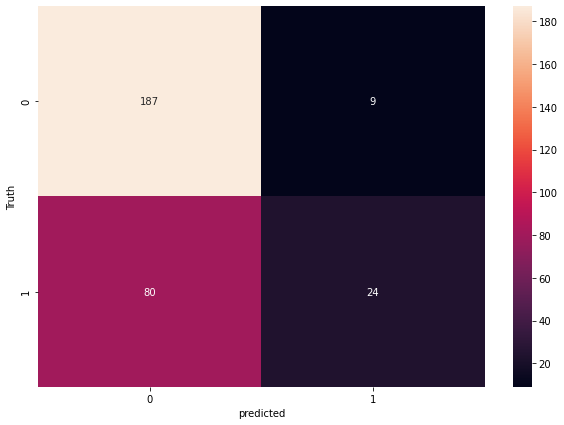

In [88]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-Score for Class = 0 is 0.81 which is relatively good. F-score of Class = 1 is 0.35 which is higher than F-score of the Random Forest model (0.35). The weighted average F-score is 0.65 which is a bit better than Random Forest (0.64).

In [89]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81       196
           1       0.73      0.23      0.35       104

    accuracy                           0.70       300
   macro avg       0.71      0.59      0.58       300
weighted avg       0.71      0.70      0.65       300



## 3. Neural Network

In this part, we use a shallow neural network for binary classification.

In [90]:
X, y = Univariate_Selection (df, n_features = 20)

                                                Specs      Score
37                              integrative_cluster_5  45.582306
6                                         her2_status  32.948072
3                                        chemotherapy  32.422593
51     3-gene_classifier_subtype_ER+/HER2- Low Prolif  31.215246
53                    3-gene_classifier_subtype_HER2+  29.915362
22                   pam50_+_claudin-low_subtype_LumA  27.257431
36                              integrative_cluster_3  21.067066
21                   pam50_+_claudin-low_subtype_Her2  19.203529
9                       lymph_nodes_examined_positive  17.360078
1                              type_of_breast_surgery  14.024467
11                        nottingham_prognostic_index  13.966838
35                              integrative_cluster_2  10.138265
12                                          pr_status   8.017459
5                           neoplasm_histologic_grade   6.610283
33  tumor_other_histologi

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [92]:
X_train.shape

(1198, 20)

In [105]:
NN = keras.Sequential([
    
    keras.layers.Dense(20, input_shape = (20, ), activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation = 'sigmoid'), 
])

NN.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  
history_class = NN.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 1s 12ms/step - loss: 0.7426 - accuracy: 0.5551 - val_loss: 0.6463 - val_accuracy: 0.6667
Epoch 2/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.6043 - val_loss: 0.6202 - val_accuracy: 0.6767
Epoch 3/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6564 - accuracy: 0.6277 - val_loss: 0.6065 - val_accuracy: 0.6767
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6516 - accuracy: 0.6569 - val_loss: 0.6051 - val_accuracy: 0.6767
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6362 - accuracy: 0.6611 - val_loss: 0.6018 - val_accuracy: 0.6767
Epoch 6/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6422 - accuracy: 0.6511 - val_loss: 0.5992 - val_accuracy: 0.6833
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6333 - accuracy: 0.6561 - val_loss: 0.5966 - val_accuracy: 0.6767
Epoch 8/100


Epoch 59/100
38/38 [==============================] - 0s 4ms/step - loss: 0.5862 - accuracy: 0.6995 - val_loss: 0.5701 - val_accuracy: 0.6967
Epoch 60/100
38/38 [==============================] - 0s 4ms/step - loss: 0.5796 - accuracy: 0.7037 - val_loss: 0.5695 - val_accuracy: 0.6933
Epoch 61/100
38/38 [==============================] - 0s 4ms/step - loss: 0.5811 - accuracy: 0.7045 - val_loss: 0.5686 - val_accuracy: 0.6933
Epoch 62/100
38/38 [==============================] - 0s 4ms/step - loss: 0.5744 - accuracy: 0.7145 - val_loss: 0.5682 - val_accuracy: 0.6933
Epoch 63/100
38/38 [==============================] - 0s 4ms/step - loss: 0.5792 - accuracy: 0.7020 - val_loss: 0.5692 - val_accuracy: 0.6967
Epoch 64/100
38/38 [==============================] - 0s 4ms/step - loss: 0.5848 - accuracy: 0.7012 - val_loss: 0.5695 - val_accuracy: 0.6967
Epoch 65/100
38/38 [==============================] - 0s 4ms/step - loss: 0.5647 - accuracy: 0.7045 - val_loss: 0.5690 - val_accuracy: 0.7033
Epoch 

This NN model has 641 parameters that should be optimized by backpropagation.

In [106]:
NN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


The following figures show the profiles of "loss" and "accuracy" with respect to epochs for the training and validation (test) datasets.

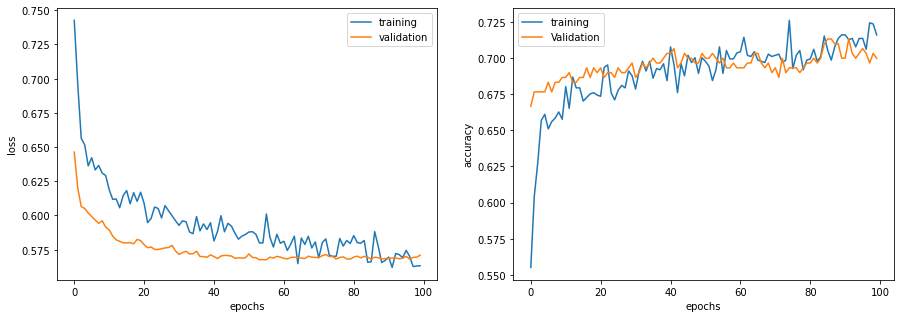

In [107]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot(history_class.history['loss'], label = 'training')
plt.plot(history_class.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_class.history['accuracy'], label = 'training')
plt.plot(history_class.history['val_accuracy'], label = 'Validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


The accuracy of the NN model on test set is around 0.70.

In [108]:
NN.evaluate(X_test, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 0.5709 - accuracy: 0.7000


[0.570914089679718, 0.699999988079071]

In [109]:
y_predicted = NN.predict(X_test)

In [110]:
y_predicted_labels = []

for ii in y_predicted:
    if ii > 0.5:
        y_predicted_labels.append(1)
    elif ii <= 0.5:
        y_predicted_labels.append(0)

Text(69.0, 0.5, 'Truth')

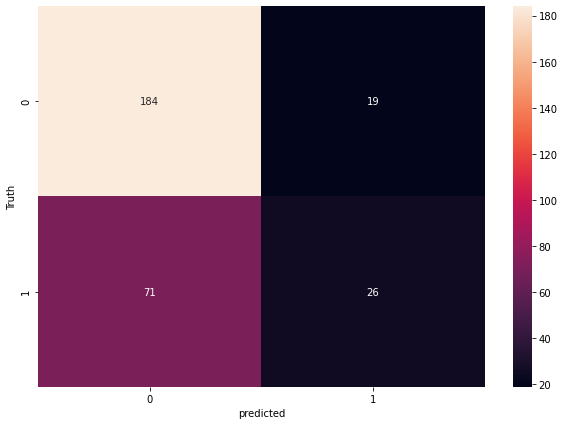

In [111]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_labels)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-Score for Class = 0 is 0.66 which is a bit higher than the F-score of the Gradient Boost. F-score of Class = 1 is 0.37 which is a bit higher than F-score of the Gradient Boost model (0.36). The weighted average F-score is 0.66.

In [112]:
print(classification_report(y_test, y_predicted_labels, zero_division = False))

              precision    recall  f1-score   support

           0       0.72      0.91      0.80       203
           1       0.58      0.27      0.37        97

    accuracy                           0.70       300
   macro avg       0.65      0.59      0.58       300
weighted avg       0.68      0.70      0.66       300



## Learning curve - High Bias Problem
### Gradient Boost Model
In this subsection, we want to evaluate the learning curve of the Gradient Boost model. The interpretation of this curve will help us to understand why the accuracy of our model is relatively low.

In [113]:
X, y = Univariate_Selection (df, n_features = 20)

                                                Specs      Score
37                              integrative_cluster_5  45.582306
6                                         her2_status  32.948072
3                                        chemotherapy  32.422593
51     3-gene_classifier_subtype_ER+/HER2- Low Prolif  31.215246
53                    3-gene_classifier_subtype_HER2+  29.915362
22                   pam50_+_claudin-low_subtype_LumA  27.257431
36                              integrative_cluster_3  21.067066
21                   pam50_+_claudin-low_subtype_Her2  19.203529
9                       lymph_nodes_examined_positive  17.360078
1                              type_of_breast_surgery  14.024467
11                        nottingham_prognostic_index  13.966838
35                              integrative_cluster_2  10.138265
12                                          pr_status   8.017459
5                           neoplasm_histologic_grade   6.610283
33  tumor_other_histologi

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.001)

In [115]:
def plot_learning_curve(train_scores, test_scores, train_sizes, fig_name, title, xlabel, ylabel):
    train_mean = 1 - np.mean(train_scores, axis = 1)

    test_mean = 1 - np.mean(test_scores, axis = 1)

    plt.plot(train_sizes, train_mean, '--',  label="Training score")
    plt.plot(train_sizes, test_mean, label="Cross-validation score")

    plt.title(title)
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel) 
    plt.legend(loc="best")
    plt.savefig(fig_name, bbox_inches='tight')

In [116]:
train_sizes, train_scores, test_scores = learning_curve \
(GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 150), \
 X_train, y_train, cv = 5, train_sizes=np.linspace(0.01, 1.0, 30))

As shown below, the training and validation errors are close to each other and the variance is low. However, we have a high bias problem because the error of training data is around 0.25. Using a more complex model such as deep neural network or adding more features related to breast cancer may solve high-bias problem.

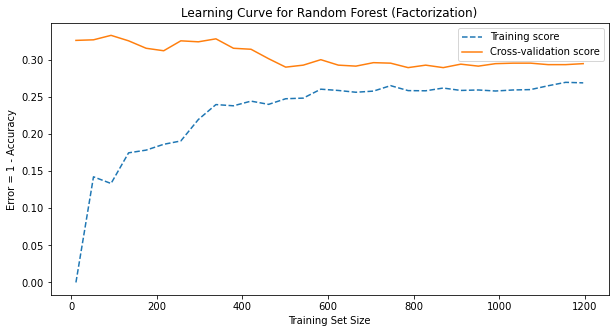

In [117]:
plt.figure(figsize=(10,5))
plot_learning_curve(train_scores,test_scores,train_sizes,"Random_Forest_Curve.png",
           "Learning Curve for Random Forest (Factorization)","Training Set Size","Error = 1 - Accuracy")

### This is end of Model 2